In [1]:
import os
# necessary when on deepnet server
os.environ['DISPLAY'] = ':0.0'

import numpy as np
from PIL import Image
from GFG import Ctx
from GFG.model import Nf
from pathlib import Path
from GFG.core import Camera
from skimage import transform
from GFG.model import Furmap, hcol, Adata
from GFG.identity import IDModel
import sys
sys.path.append('../scripts/generate_stimuli')
from generate_backgrounds import phase_scramble_image

In [128]:
base_nf = Nf.from_default()
#furmap = Furmap(hcol=hcol['Dark Golden Brown'], nlayers=120, density=0.15)
#furmap.material.split_newmtl(mat_groups = base_nf.material_groups,
#                             fvt = base_nf.face_tuple.fv,
#                             vt = base_nf.vertex_tuple.dSvt,
#                             groupfidx = base_nf.groupfindex)
#base_nf.attach_fur(furmap, name='fur')

### SETUP CAMERA + DEFINITION PARAMETERS
# Setup openGL context + camera
ctx = Ctx(hidden=True)
base_nf.attach(ctx)  # attach to openGL context
ctx._camera[0] = Camera(
    ctx.win, (112, 112), 4.,  # res, renderscale
    target=[-11.5644, -13.0381, 0],
    eye = [-11.5644 + 32, -13.0381, 250],
    up = [0, 1, 0],
    FOV = 50,
    near = 100.,
    far = 1000.
)
ctx.assign_camera(0)

In [129]:
mu = base_nf.v[base_nf.groupvindex[base_nf.groupnames.index('face')]].mean(axis=0)
mu[-1] = base_nf.v[base_nf.groupvindex[base_nf.groupnames.index('head')]].mean(axis=0)[-1]
#mu = base_nf.v[base_nf.groupvindex[base_nf.groupnames.index('head')]].mean(axis=0)


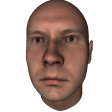

In [130]:
ctx.set_lights(Path('../data/lights.yaml'))
ctx.lights[0]._worldpos[-1] = 250
#ctx.transform_lights(0, -90, 0, ctx.lights[0]._worldpos, order='xyzt')
base_nf.skeleton.transform(x=0, y=0, z=0, t=-mu, order='txyz', replace=True)
base_nf.skeleton.transform(x=0, y=0, z=0, t=mu, order='txyz')
img = ctx.render('image')
img.save('../data/orig3.png')
img

In [ ]:
base_nf.transform_model(0, 0, 0, [0, 0, 0], order='txyz', replace=True)
base_nf.transform_model(15, 25, 0, [40, -10, 0], order='xyzt', replace=False)
img = ctx.render('image')
img.save('../data/rot.png')
img

In [ ]:
base_nf.transform_model(0, 0, 0, [0, 0, 0], order='txyz', replace=True)
base_nf.transform_model(15, 25, 0, [0, 0, 0], order='xyzt', replace=False)
img = ctx.render('image')

img_arr = np.array(img)
tform = transform.EuclideanTransform(translation=(120, 80))
img_arr = transform.warp(img_arr, tform.inverse)
img_arr *= 255
img = Image.fromarray(img_arr.astype(np.uint8))
img.convert('RGBA').save(str('../data/trans+rot.png'))
img


In [ ]:
ctx.set_lights(Path('../lights.yaml'))
ctx.transform_lights(45, 45, 0, [0, 0, 0])

base_nf.transform_model(0, 0, 0, [0, 0, 0], order='txyz', replace=True)
base_nf.transform_model(15, 25, 0, [0, 0, 0], order='xyzt', replace=False)
img = ctx.render('image')

img_arr = np.array(img)
tform = transform.EuclideanTransform(translation=(120, 80))
img_arr = transform.warp(img_arr, tform.inverse)
img_arr *= 255
img = Image.fromarray(img_arr.astype(np.uint8))
img.convert('RGBA').save(str('../data/trans+rot+lights.png'))
img

In [ ]:
ctx.set_lights(Path('../lights.yaml'))
ctx.transform_lights(45, 45, 45, [0, 0, 0])

base_nf.transform_model(0, 0, 0, [0, 0, 0], order='txyz', replace=True)
base_nf.transform_model(15, 25, 0, [0, 0, 0], order='xyzt', replace=False)
img = ctx.render('image')

img_arr = np.array(img)
tform = transform.EuclideanTransform(translation=(120, 80))
img_arr = transform.warp(img_arr, tform.inverse)
img_arr *= 255
bg_rgb = phase_scramble_image(img_arr.copy(), None, is_image=False, shuffle_phase=False, grayscale=False)
img_rgb, img_a = img_arr[..., :3], img_arr[..., 3, None] / 255.
img_arr = (img_rgb * img_a) + (bg_rgb * (1 - img_a))  # alpha blend
img_arr = np.dstack((img_arr, np.ones((512, 512)) * 255)).astype(np.uint8)
img = Image.fromarray(img_arr.astype(np.uint8))
img.convert('RGBA').save(str('../data/trans+rot+lights+bg.png'))
bg = Image.fromarray(bg_rgb.astype(np.uint8))
bg.convert('RGBA').save('../data/orig_background.png')